<a href="https://colab.research.google.com/github/Youngdeuk-Koo/KNLP/blob/main/seq_2_seq_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
%cd ../

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#0.프로젝트 진행중 생겼던 문제점과 해결법

###1.크롤링 후 압축푸는거만 반나절 걸림(...)
    1.1 url을 제대로 확인 하지 않아 빈 압축파일을 생성하고 있었음
    1.2 url 확인 후 해결 
 
###2.어떤 문자를 제거 하고 어떤 문자는 살려야 하는가?

    2.1 ('&#8212;, ¡°I, ¡°, ¡± (CNN))등 불용어 제거

    2.2 [. , ' "] 만 남겨 봤으나 결과 좋지 않음 (Loss 4.0 ~ 5.0)

    2.2 문자와 숫자만 남겨 봤으나 조금 좋아 졌을뿐 결과는 큰 의미 없음 (Loss 1.0 ~ 3.0)

    2.4 한글과 영어 외에 모든 문자 삭제시 가장 좋은 결과 (Loss 0.01 ~ 0.03)

###3.VOCAB_SIZE로 인한 GPU OOM에러
    
    3.1 문장이나 토큰의 길이와 상관없이 VOCAB_SIZE가 14,000이 넘으면 에러

    3.2 적당한 VOCAB_SIZE를 위한 문장길이들만 추출

    3.3 패딩 격차를 줄이기 위해 10~80개의 문장들만 추출

    3.4 VOCAB_SIZE 13,000으로 시작

###4.과적합과 로스 폭주를 막기 위한 적당한 에포크 찾기

    4.1 에포크 10 (택도 없음)

    4.2 에포크 20 (부족함)

    4.3 에포크 40 (로스율 0.007 과적합이라 생각됨) or 로스율 폭주(Loss가 0.01에서 5.1로 폭주)

    4.4 에포크 35 로스율 0.02때로 적당하다 판단

###5.새로 입력되는 문장 패딩의 오류

    5.1 지속되는 차원 불일치 오류(어디서 에러가 생기는지 확인이 쉽지 않았음)

    5.2 입력 문장의 패딩쪽에서 에러가 생기는걸 발견

    5.3 입력문장의 패딩이 [27, 80, 55, 0 .... ,0]이 아닌 [[27, 0, 0, ... ,0], [80, 0, 0, ... ,0], [55, 0, 0, ... ,0]]로 차원 오류가 생겼음

    5.4 입력되는 토큰화의 리스트 플래튼 후 재정립

    5.5 문제 해결





#1.데이터 크롤링후 압축해제

In [ ]:
import tensorflow as tf
import numpy as np
import os
import tarfile
import urllib.request

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

download_root = 'https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/'
train_url = download_root + 'korean-english-park.train.tar.gz'
test_url = download_root + 'korean-english-park.test.tar.gz'

_PATH = os.path.join('kor_eng_LangFile') 

def fetch_spam_data(spam_url=test_url, ham_url=train_url, spam_path=_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("Korean-english-park.train.tar.gz", ham_url), ("Korean-english-park.test.tar.gz", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
            
        # 압축해제
        tar_gz_file = tarfile.open(path)
        tar_gz_file.extractall(path=_PATH)
        tar_gz_file.close()

fetch_spam_data()

#2.데이터 불러오기

In [ ]:
with open('/content/kor_eng_LangFile/korean-english-park.train.ko', "r") as f:
    kor = f.read().splitlines()

with open('/content/kor_eng_LangFile/korean-english-park.train.en', "r") as f:
    eng = f.read().splitlines()

print('한글 길이 :', len(kor))
print('영어 길이 :', len(eng))

한글 길이 : 94123
영어 길이 : 94123


#3.중복제거

In [ ]:
pairs = [w for w in zip(kor, eng)]
pair = list(set(pairs))
print('중복 제거후 문장 길이 :', len(pair))
print()
print('문장 일부 확인 :')
print(pair[:2])

중복 제거후 문장 길이 : 78968

문장 일부 확인 :
[('카수리 외무장관은 CNN과의 인터뷰에서 “파키스탄과 아프가니스탄 국경 인근 부족 거주 산악지역에 8만5000명의 병력을 이미 배치했다”고 말했다.', 'Khurshid Kasuri further told CNN\'s "Late Edition with Wolf Blitzer" that 85,000 Pakistani troops were already in the Federally Administered Tribal Areas, a mountainous and notoriously dangerous region at the porous border between Pakistan and Afghanistan.'), ('TAIPEI, Taiwan (CNN) / 이수지(JOINS)', 'Protests mark China envoy`s Taiwan trip')]


#4.문장 길이 확인

In [ ]:
k_min_len = 999
k_max_len = 0

e_min_len = 999
e_max_len = 0

k_sum_len = 0
e_sum_len = 0

for k_sen, e_sen in pair:
    k_length = len(k_sen)
    e_length = len(e_sen)
    if k_min_len > k_length : k_min_len = k_length
    if e_min_len > e_length : e_min_len = e_length

    if k_max_len < k_length : k_max_len = k_length
    if e_max_len < e_length : e_max_len = e_length
    k_sum_len += k_length
    e_sum_len += e_length


print("문장의 최단 길이 :", k_min_len)
print("문장의 최장 길이 :", k_max_len)

print("문장의 최단 길이 :", e_min_len)
print("문장의 최장 길이 :", e_max_len)

문장의 최단 길이 : 1
문장의 최장 길이 : 377
문장의 최단 길이 : 1
문장의 최장 길이 : 605


#5.문장 길이 분포 확인

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


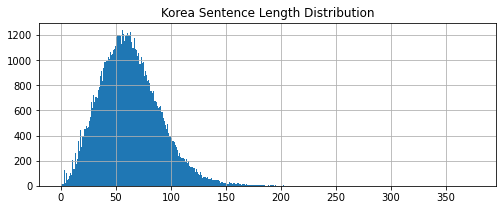

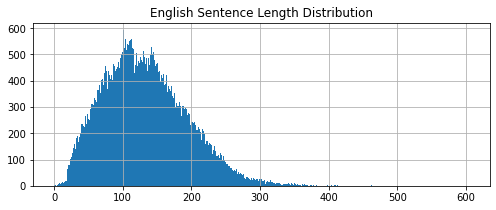

In [ ]:
import matplotlib.pyplot as plt

kor_length = np.zeros((k_max_len), dtype=np.uint)
eng_length = np.zeros((e_max_len), dtype=np.uint)

for k_sen, e_sen in pair: #중복이 제거된 코퍼스
    kor_length[len(k_sen)-1] += 1
    eng_length[len(e_sen)-1] += 1


plt.figure(figsize=[18, 3])
plt.subplot(1, 2, 1)
plt.title("Korea Sentence Length Distribution")
plt.bar(range(k_max_len), kor_length, width=1.0)
plt.grid()

plt.figure(figsize=[18, 3])
plt.subplot(1, 2, 2)
plt.bar(range(e_max_len), eng_length, width=1.0)
plt.title("English Sentence Length Distribution")
plt.grid()
plt.show()

#6.토크나이징 및 문장 전처리(진행중)

In [ ]:
from konlpy.tag import Mecab
import re

def preprocess_sentence(sentence, token=False):
    if token == False:      
        sentence = sentence.replace('&#8212;', '')
        sentence = sentence.replace('¡°I', '')
        sentence = sentence.replace('¡°', '')
        sentence = sentence.replace('¡±', '')
        sentence = sentence.replace('¡¯', '')
        sentence = re.sub('[-=+,#/\?:;^$.@*\’"“”※~&%ㆍ_!』\\‘|\(\)\[\]\<\>`\'…》.]','', sentence)
        sentence = re.sub(r"[^가-힣 ]", "", sentence)

        return sentence
    
    if token == True:
        sentence = sentence.lower().strip()
        sentence = sentence.replace('&#8212;', '')
        sentence = sentence.replace('¡°I', '')
        sentence = sentence.replace('¡°', '')
        sentence = sentence.replace('¡±', '')
        sentence = sentence.replace('¡¯', '')      
        sentence = re.sub('[-=+,#/\?:;^$.@*\’"“”※~&%ㆍ_!』\\‘|\(\)\[\]\<\>`\'…》.]','', sentence)
        sentence = re.sub(r"[^a-z ]", "", sentence)
        sentence = sentence.strip()
        sentence = '<start> ' + sentence
        sentence += ' <end>'

        return sentence

#7.분포에 맞는 문장 길이 선택

In [ ]:
kor_corpus = []
eng_corpus = []
mecab = Mecab()
num_examples = len(pair)

for kor, eng in pair[:num_examples]:
    k_cop = preprocess_sentence(kor, token=False)     
    e_cop = preprocess_sentence(eng, token=True) 
    m_k_cop = mecab.morphs(k_cop)

    if 10 <= len(m_k_cop) <= 80 and 15 <= len(e_cop) <= 85:       # 보캡 사이즈 조절                
        kor_corpus.append(m_k_cop) 
        eng_corpus.append(e_cop)

In [ ]:
print("한글 확인 :", kor_corpus[3000])
print("영어 확인 :", eng_corpus[3000])
print()
print("한글 문장 갯수 :", len(kor_corpus))
print("영어 문장 갯수 :", len(eng_corpus))
print()

k_maxlen = max([len(w) for w in kor_corpus])
e_maxlen = max([len(w) for w in eng_corpus])

k_minlen = min([len(w) for w in kor_corpus])
e_minlen = min([len(w) for w in eng_corpus])

print('한글 문장 최장 길이 :', k_maxlen)
print('한글 문장 최단 길이 :', k_minlen)
print('영어 문장 최장 길이 :', e_maxlen)
print('영어 문장 최단 길이 :', e_minlen)

한글 확인 : ['강도', '는', '이런', '대응', '을', '전혀', '예상', '하', '지', '못한', '듯', '했', '다']
영어 확인 : <start> the guy obviously was not expecting such a reaction <end>

한글 문장 갯수 : 10042
영어 문장 갯수 : 10042

한글 문장 최장 길이 : 73
한글 문장 최단 길이 : 10
영어 문장 최장 길이 : 85
영어 문장 최단 길이 : 22


#8.전처리 확인용 텍스트 파일 생성(진행중)

In [ ]:
with open('한글 전처리 확인용', 'w', encoding='utf8') as f:
    f.write('\n'.join(map(str, kor_corpus)))

with open('영어 전처리 확인용', 'w', encoding='utf8') as f:
    f.write('\n'.join(map(str, eng_corpus)))

#9.문장 토큰화 및 보캡사이즈 확인

In [ ]:
def tokenize(corpus, maxlen):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)

    return tensor, tokenizer

In [ ]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus, k_maxlen)
eng_tensor, eng_tokenizer = tokenize(eng_corpus, e_maxlen)

print("Korean Vocab Size :", len(kor_tokenizer.index_word))
print("English Vocab Size :", len(eng_tokenizer.index_word))

Korean Vocab Size : 14257
English Vocab Size : 12977


In [ ]:
k_t_maxlen = max([len(w) for w in kor_tensor])
e_t_maxlen = max([len(w) for w in eng_tensor])

print('한글 패딩 길이 :', k_t_maxlen)
print('영어 패딩 길이 :', e_t_maxlen)

한글 패딩 길이 : 73
영어 패딩 길이 : 85


#10.데이터 셋 나누기

In [ ]:
from sklearn.model_selection import train_test_split

kor_train, kor_val, eng_train, eng_val = train_test_split(kor_tensor, eng_tensor, test_size = 0.2)

#11.바다나우 어텐션 클래스

In [ ]:
# 바다나우 어텐션 클래스 만들기
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape : [batch x length x units]
        # h_dec shape : [batch x units]

        h_enc = self.w_enc(h_enc)
        # print('한글 인코더 출력 값 행렬 :', h_enc)
        # print()
        # print('차원 추가 전 한글 끝 시퀀스 행렬 :', h_dec)
        # print()
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        # print('차원 추가 후 한글 끝 시퀀스 행렬 :', h_dec)
        # print()

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        # print('컴바인 Dense[1](하.탄젠트(끝 시퀀스 + 인코더 출력)) 행렬 :', score)
        # print()

        attn = tf.nn.softmax(score, axis = 1)
        # print('attn(소프트 맥스 처리된) 행렬 :', attn)
        # print()

        context_vec = attn * h_enc
        # print('context_vec(attn * 인코더 출력)) 행렬 :', context_vec)
        # print()
        context_vec = tf.reduce_sum(context_vec, axis=1)
        # print('다 더한 context_vec 행렬 :', context_vec)
        # print()
        
        return context_vec, attn

#11.인코더 클래스

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

    def call(self, x):
        # print('한글 토큰 입력 행렬 :', x)
        # print()
        out = self.embedding(x)
        # print('한글 토큰 임베딩후 행렬 :', out )
        # print()
        out = self.gru(out)
        # print('한글 토큰 GRU후 행렬 :', out)
        # print()

        return out

#12.디코더 클래스

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units= dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state= True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
    
    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        # print('다 더한 context_vec 행렬 :', context_vec)
        # print()
        # print('attn(소프트 맥스 처리된) 행렬 :', attn)
        # print()
        # print('영어 토큰 입력 행렬 :', x)
        # print()
        out = self.embedding(x)
        # print('영어 토큰 임베딩후 행렬 :', out)
        # print()
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        # print('context_vec와 임베딩한 영어 concat 행렬  :', out)
        # print()

        out, h_dec = self.gru(out)
        # print('GRU를 거친 concat 행렬 :', out)
        # print()
        # print('GRU후 return_state 행렬 :', h_dec)
        # print()
        out = tf.reshape(out, (-1, out.shape[2]))
        # print('0, 1 차원을 모두 곱한 reshape 행렬 :', out)
        # print()
        out = self.fc(out)
        # print('최종 Dense 행렬 :', out)
        # print()

        return out, h_dec, attn

#13.인코더 및 디코더 생성 후 샘플 테스트

In [ ]:
BATCH_SIZE = 64
src_vocab_size = len(kor_tokenizer.index_word)+1
tgt_vocab_size = len(eng_tokenizer.index_word)+1

units = 1024
embedding_dim = 512

encoder = Encoder(src_vocab_size, embedding_dim, units)
decoder = Decoder(tgt_vocab_size, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print('샘플 인코더 출력 값 :', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))
print('샘플 스테이트 출력 값 :', sample_state.shape)

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_state, sample_output)

print('샘플 디코더 출력 값 :', sample_logits.shape)
print('샘플 디코더 히든 스테이트 값 :', h_dec.shape)
print('어텐션 값 :', attn.shape)

샘플 인코더 출력 값 : (64, 30, 1024)
샘플 스테이트 출력 값 : (64, 1024)
샘플 디코더 출력 값 : (64, 12978)
샘플 디코더 히든 스테이트 값 : (64, 1024)
어텐션 값 : (64, 30, 1)


#14.손실함수 클래스

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype = loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

#15.Train 학습 함수

In [ ]:
@tf.function # 가속 연산
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]                # kor_train 행의 갯수 (2228개)
    loss = 0                          # 손실 시작 0

    with tf.GradientTape() as tape:   # 학습하면서 발생한 모든 연산을 기록하는 테이프
        enc_out = encoder(src)        # 인코딩된 kor_train / shape(2228, 57, 1024)
        h_dec = enc_out[:, -1]        # 인코딩된 kor_train의 각 문장의 끝 시퀀스만 추출 / shape(2228, 1024)
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)  # 문장의 수(2228개)만큼 '<start>'의 인덱스[1] 로 된 (2228, 1) 차원 생성                                                                          

        for t in range(1, tgt.shape[1]):                         # 1부터 eng_train의 열(문장내 단어수[60]) 만큼 반복 할때
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)    # 인덱스[1] (2228, 1), 문장의 끝 시퀀스(2228, 1024), 인코딩된 한글(2228, 57, 1024)

            loss += loss_function(tgt[:, t], pred)               # 영어 토큰과 예측값 비교하여 loss에 누적한다
            dec_src = tf.expand_dims(tgt[:, t], 1)               # eng_train의 차원(2228, )을 증가(2228, 1)시킨 후 dec_src로 업데이트
        
    batch_loss = (loss / int(tgt.shape[1]))                      # 누적된 로스를 문장의 길이로 나누어 배치 로스를 구한다

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

#16.Test 학습 함수

In [ ]:
@tf.function
def eval_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

#17. 전체 학습

In [ ]:
# Training Process
from tqdm import tqdm
import random

EPOCHS = 35

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
        total_loss += batch_loss

        t.set_description_str('Train Epoch %2d' % (epoch +1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy()/ (batch+1)))

    test_loss = 0

    idx_list = list(range(0, kor_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(kor_val[idx:idx+BATCH_SIZE],
                                    eng_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    optimizer,
                                    eng_tokenizer)
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch+1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy()/ (test_batch+1)))

Test Epoch 35: 100%|██████████| 32/32 [00:25<00:00,  1.28it/s, Test Loss 0.0153]


#18.새로운 입력으로 들어오는 문장 정리 함수

In [ ]:
from itertools import chain

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_train.shape[-1], kor_train.shape[-1]))
    sentence = preprocess_sentence(sentence, token=False)

    inputs = kor_tokenizer.texts_to_sequences(mecab.morphs(sentence))
    flatten = [list(chain(*inputs))]
    inputs = tf.keras.preprocessing.sequence.pad_sequences(flatten, maxlen = kor_train.shape[-1], padding= 'post')
  
    result = ''
    enc_out = encoder(inputs)
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)
    
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

#19. 문장 일치 비교 그래프 생성 함수

In [ ]:
# import matplotlib.ticker as ticker
# import matplotlib.pyplot as plt

# def plot_attention(attention, sentence, predicted_sentence):

#     plt.rcParams['font.family'] ='Malgun Gothic'
#     plt.rcParams['axes.unicode_minus'] = False

#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(1, 1, 1)
#     ax.matshow(attention, cmap='viridis')

#     fontdict = {'fontsize': 14}

#     ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
#     ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()

#20.번역 확인 함수

In [ ]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input : %s' % (sentence))
    print('Output : {}'.format(result),'\n')

    attention = attention[:len(result.split()), :len(sentence.split())]
    # plot_attention(attention, sentence.split(), result.split(' '))

In [ ]:
sentence = ['그는 미국의 대통령',
            '그녀는 휴식이 필요해',
            '이스라엘은 이란과 전쟁을 준비한다',
            '지구의 날씨는 점점 위험하다',
            '미군은 이라크에서 철수 했다']

for word in sentence:
    translate(str(word), encoder, decoder)

Input : 그는 미국의 대통령
Output : he is the americans are <end>  

Input : 그녀는 휴식이 필요해
Output : she was at home <end>  

Input : 이스라엘은 이란과 전쟁을 준비한다
Output : israel considers iran for terror <end>  

Input : 지구의 날씨는 점점 위험하다
Output : the weather on earth could face <end>  

Input : 미군은 이라크에서 철수 했다
Output : the us military is to us troops in iraq <end>  

